In [8]:
import polars as pl
import pickle
import numpy as np
from collections import Counter

## 1. Load Ground Truth Data

In [17]:
# Load groundtruth.pkl
groundtruth_path = 'data/final_groundtruth.pkl'

with open(groundtruth_path, 'rb') as f:
    groundtruth = pickle.load(f)

print(f"Total users in groundtruth: {len(groundtruth)}")
groundtruth.head()

Total users in groundtruth: 644970


,customer_id,item_id
0,2337685,[0020010000305]
1,7934799,[0020010000438]
2,2052333,"[3513000000064, 2403000000004, 3460000000018, ..."
3,6548920,[6701000000004]
4,368770,"[5420000000003, 5420000000002, 1371000000002, ..."


In [18]:
# Giả sử groundtruth là DataFrame với item_id là chuỗi dạng list, ví dụ: '[0020010000305,0020010000438]'
import pandas as pd

# Nếu groundtruth là dict, convert sang DataFrame trước


# Nếu item_id là list string, chuyển thành list thực sự
if groundtruth["item_id"].apply(lambda x: isinstance(x, str)).all():
    groundtruth["item_id"] = groundtruth["item_id"].str.strip("[]").str.split(",")

# Tách từng item_id thành dòng riêng
gt_df = groundtruth.explode("item_id").reset_index(drop=True)
gt_df["item_id"] = gt_df["item_id"].str.strip()
gt_df.head()

,customer_id,item_id
0,2337685,0020010000305
1,7934799,0020010000438
2,2052333,3513000000064
3,2052333,2403000000004
4,2052333,3460000000018


In [21]:
type(gt_df)

pandas.core.frame.DataFrame

In [23]:
gt_df = pl.from_pandas(gt_df)
print(f"\nTotal ground truth pairs (user, item): {len(gt_df)}")
gt_df.head()


Total ground truth pairs (user, item): 2665926


customer_id,item_id
i32,str
2337685,"""0020010000305"""
7934799,"""0020010000438"""
2052333,"""3513000000064"""
2052333,"""2403000000004"""
2052333,"""3460000000018"""


In [8]:
gt_df.head()

customer_id,item_id
i32,list[str]
2337685,"[""0020010000305""]"
7934799,"[""0020010000438""]"
2052333,"[""3513000000064"", ""2403000000004"", … ""2125000000025""]"
6548920,"[""6701000000004""]"
368770,"[""5420000000003"", ""5420000000002"", … ""6768000000003""]"


In [24]:
# Đếm unique items
unique_items_in_gt = gt_df["item_id"].n_unique()
print(f"Unique items in ground truth: {unique_items_in_gt}")

# Đếm số items per user
items_per_user = gt_df.group_by("customer_id").agg(pl.count().alias("num_items"))
print(f"\nStatistics of items per user:")
print(items_per_user["num_items"].describe())

Unique items in ground truth: 11816

Statistics of items per user:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 644970.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 4.133411 │
│ std        ┆ 4.647266 │
│ min        ┆ 1.0      │
│ 25%        ┆ 1.0      │
│ 50%        ┆ 2.0      │
│ 75%        ┆ 5.0      │
│ max        ┆ 97.0     │
└────────────┴──────────┘


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_36024\2400847503.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  items_per_user = gt_df.group_by("customer_id").agg(pl.count().alias("num_items"))


## 2. Load Item Catalog với Sale Status

In [25]:
# Load item data
item_df = pl.read_parquet('data/table/item_data.parquet')

print(f"Total items in catalog: {item_df.height}")
print(f"\nColumns: {item_df.columns}")
print(f"\nSample data:")
item_df.select(["item_id", "sale_status"]).head(10)

Total items in catalog: 27332

Columns: ['item_id', 'price', 'category_l1_id', 'category_l1', 'category_l2_id', 'category_l2', 'category_l3_id', 'category_l3', 'category_id', 'category', 'brand', 'creation_timestamp', 'gender_target', 'age_group', 'item_type', 'gp', 'sale_status', 'created_date_year', 'created_date_month', 'created_date_day', 'updated_date_year', 'updated_date_month', 'updated_date_day', 'price_log', 'gp_log']

Sample data:


item_id,sale_status
str,i32
"""0502020000004""",0
"""0010290040150""",0
"""0008010000015""",0
"""0020010000094""",0
"""0020010000098""",0
"""0024181040235""",0
"""0008180000017""",0
"""0020010000150""",0
"""0501030000126""",0


In [26]:
# Kiểm tra distribution của sale_status
print("Distribution of sale_status in catalog:")
sale_status_dist = item_df.group_by("sale_status").agg(pl.count().alias("count")).sort("count", descending=True)
sale_status_dist

Distribution of sale_status in catalog:


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_36024\690069880.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  sale_status_dist = item_df.group_by("sale_status").agg(pl.count().alias("count")).sort("count", descending=True)


sale_status,count
i32,u32
0,22762
1,4570


## 3. Join Ground Truth với Item Catalog

In [27]:
# Join để lấy sale_status của items trong groundtruth (dùng pandas, sau đó convert lại sang polars nếu cần)
# Nếu gt_df là pandas DataFrame, item_df là polars DataFrame

# Đảm bảo gt_df là pandas DataFrame
if 'pandas' in str(type(gt_df)):
    item_df_pd = item_df.to_pandas() if 'polars' in str(type(item_df)) else item_df
    gt_with_status = gt_df.merge(item_df_pd[['item_id', 'sale_status']], on='item_id', how='left')
    print(f"Total records after join: {len(gt_with_status):,}")
    display(gt_with_status.head(10))
    # Nếu muốn dùng tiếp polars:
    gt_with_status = pl.DataFrame(gt_with_status)
else:
    # Nếu gt_df là polars DataFrame
    gt_with_status = gt_df.join(
        item_df.select(["item_id", "sale_status"]),
        on="item_id",
        how="left"
    )
    print(f"Total records after join: {gt_with_status.height:,}")
    print(gt_with_status.head(10))

Total records after join: 2,665,926
shape: (10, 3)
┌─────────────┬───────────────┬─────────────┐
│ customer_id ┆ item_id       ┆ sale_status │
│ ---         ┆ ---           ┆ ---         │
│ i32         ┆ str           ┆ i32         │
╞═════════════╪═══════════════╪═════════════╡
│ 2337685     ┆ 0020010000305 ┆ 1           │
│ 7934799     ┆ 0020010000438 ┆ 1           │
│ 2052333     ┆ 3513000000064 ┆ 0           │
│ 2052333     ┆ 2403000000004 ┆ 1           │
│ 2052333     ┆ 3460000000018 ┆ 1           │
│ 2052333     ┆ 4280000000035 ┆ 1           │
│ 2052333     ┆ 3953000000412 ┆ 0           │
│ 2052333     ┆ 4005000000031 ┆ 1           │
│ 2052333     ┆ 2125000000025 ┆ 0           │
│ 6548920     ┆ 6701000000004 ┆ 1           │
└─────────────┴───────────────┴─────────────┘


## 4. Phân tích Tình trạng Sản phẩm

In [28]:
# Đếm theo sale_status
status_count = gt_with_status.group_by("sale_status").agg(
    pl.count().alias("count")
).sort("count", descending=True)

print("Distribution of sale_status in ground truth items:")
print(status_count)

# Tính percentage
total_gt_items = gt_with_status.height
status_count_pct = status_count.with_columns(
    (pl.col("count") / total_gt_items * 100).round(2).alias("percentage")
)
print("\nWith percentage:")
status_count_pct

Distribution of sale_status in ground truth items:
shape: (2, 2)
┌─────────────┬─────────┐
│ sale_status ┆ count   │
│ ---         ┆ ---     │
│ i32         ┆ u32     │
╞═════════════╪═════════╡
│ 1           ┆ 2222917 │
│ 0           ┆ 443009  │
└─────────────┴─────────┘

With percentage:


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_36024\232351972.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count")


sale_status,count,percentage
i32,u32,f64
1,2222917,83.38
0,443009,16.62


In [29]:
# Phân loại chi tiết (sale_status là 0/1, không phải string)
# 1 = active (còn bán), 0 = inactive (không bán)
active_items = gt_with_status.filter(pl.col("sale_status") == 1)
inactive_items = gt_with_status.filter(
    (pl.col("sale_status") == 0) & (pl.col("sale_status").is_not_null())
)
missing_items = gt_with_status.filter(pl.col("sale_status").is_null())

print(f"="*60)
print(f"SUMMARY REPORT: Ground Truth Item Availability")
print(f"="*60)
print(f"Total ground truth items (user-item pairs): {total_gt_items:,}")
print(f"\n1. ACTIVE (sale_status=1, Còn bán):        {active_items.height:>10,} ({active_items.height/total_gt_items*100:.2f}%)")
print(f"2. INACTIVE (sale_status=0, Không còn bán): {inactive_items.height:>10,} ({inactive_items.height/total_gt_items*100:.2f}%)")
print(f"3. MISSING (Không tồn tại trong catalog):  {missing_items.height:>10,} ({missing_items.height/total_gt_items*100:.2f}%)")
print(f"="*60)

# Tổng hợp unavailable
unavailable = inactive_items.height + missing_items.height
print(f"\nTổng KHÔNG KHẢ DỤNG: {unavailable:,} ({unavailable/total_gt_items*100:.2f}%)")

SUMMARY REPORT: Ground Truth Item Availability
Total ground truth items (user-item pairs): 2,665,926

1. ACTIVE (sale_status=1, Còn bán):         2,222,917 (83.38%)
2. INACTIVE (sale_status=0, Không còn bán):    443,009 (16.62%)
3. MISSING (Không tồn tại trong catalog):           0 (0.00%)

Tổng KHÔNG KHẢ DỤNG: 443,009 (16.62%)


## 5. Phân tích theo Unique Items

In [30]:
# Unique items analysis
unique_gt_items = gt_with_status.select(["item_id", "sale_status"]).unique()

unique_status = unique_gt_items.group_by("sale_status").agg(
    pl.len().alias("unique_count")
).sort("unique_count", descending=True)

print(f"="*60)
print(f"UNIQUE ITEMS ANALYSIS")
print(f"="*60)
print(f"Total unique items in ground truth: {unique_gt_items.height:,}")
print(f"\nBreakdown by status:")
print(unique_status)

# Percentage (1 = active, 0 = inactive)
unique_active = unique_gt_items.filter(pl.col("sale_status") == 1).height
unique_unavailable = unique_gt_items.height - unique_active

print(f"\nUnique ACTIVE items (sale_status=1):        {unique_active:>10,} ({unique_active/unique_gt_items.height*100:.2f}%)")
print(f"Unique UNAVAILABLE items (sale_status=0 or null): {unique_unavailable:>10,} ({unique_unavailable/unique_gt_items.height*100:.2f}%)")
print(f"="*60)

UNIQUE ITEMS ANALYSIS
Total unique items in ground truth: 11,816

Breakdown by status:
shape: (2, 2)
┌─────────────┬──────────────┐
│ sale_status ┆ unique_count │
│ ---         ┆ ---          │
│ i32         ┆ u32          │
╞═════════════╪══════════════╡
│ 0           ┆ 9489         │
│ 1           ┆ 2327         │
└─────────────┴──────────────┘

Unique ACTIVE items (sale_status=1):             2,327 (19.69%)
Unique UNAVAILABLE items (sale_status=0 or null):      9,489 (80.31%)


## 6. Impact Analysis: Ảnh hưởng đến Users

In [31]:
# Phân tích users bị ảnh hưởng bởi unavailable items
users_with_unavailable = gt_with_status.filter(
    (pl.col("sale_status") != 1) | (pl.col("sale_status").is_null())
).select("customer_id").unique()

print(f"Users có ít nhất 1 item KHÔNG khả dụng: {users_with_unavailable.height:,}")
print(f"Tỷ lệ users bị ảnh hưởng: {users_with_unavailable.height/len(groundtruth)*100:.2f}%")

# Tính % unavailable items per user
user_unavailable_rate = gt_with_status.group_by("customer_id").agg([
    pl.len().alias("total_items"),
    pl.sum((pl.col("sale_status") != 1) | (pl.col("sale_status").is_null())).alias("unavailable_count")
]).with_columns(
    (pl.col("unavailable_count") / pl.col("total_items") * 100).round(2).alias("unavailable_pct")
)

print(f"\nDistribution of unavailable percentage per user:")
print(user_unavailable_rate["unavailable_pct"].describe())

# Số users có 100% items unavailable
users_all_unavailable = user_unavailable_rate.filter(pl.col("unavailable_pct") == 100).height
print(f"\nUsers với 100% items KHÔNG khả dụng: {users_all_unavailable:,} ({users_all_unavailable/len(groundtruth)*100:.2f}%)")

Users có ít nhất 1 item KHÔNG khả dụng: 252,211
Tỷ lệ users bị ảnh hưởng: 39.10%


TypeError: invalid input for `col`

Expected `str` or `DataType`, got 'Expr'.

## 7. Recommendation: Items cần filter ra

In [32]:
# List các unique items cần filter
items_to_filter = unique_gt_items.filter(
    (pl.col("sale_status") != 1) | (pl.col("sale_status").is_null())
)["item_id"].to_list()

print(f"\n📋 RECOMMENDATION:")
print(f"Cần filter ra {len(items_to_filter):,} unique items KHÔNG khả dụng từ candidate generation")
print(f"\nTop 20 items KHÔNG khả dụng (sample):")
print(items_to_filter[:20])

# Save to file for filtering
with open('unavailable_items.txt', 'w') as f:
    for item in items_to_filter:
        f.write(f"{item}\n")
        
print(f"\n✅ Saved unavailable items list to 'unavailable_items.txt'")


📋 RECOMMENDATION:
Cần filter ra 9,489 unique items KHÔNG khả dụng từ candidate generation

Top 20 items KHÔNG khả dụng (sample):
['0919000000104', '0020090000007', '0924285630002', '3793000000007', '3953000000306', '0037000000016', '4279000000001', '4849000000002', '0099000000017', '6999000000004', '0957000000022', '3523000000127', '6602000000053', '3499000000009', '0972000000014', '6048000000003', '4839000000001', '3533000000077', '3390000000092', '3987000000005']

✅ Saved unavailable items list to 'unavailable_items.txt'


## 8. Visualize Distribution

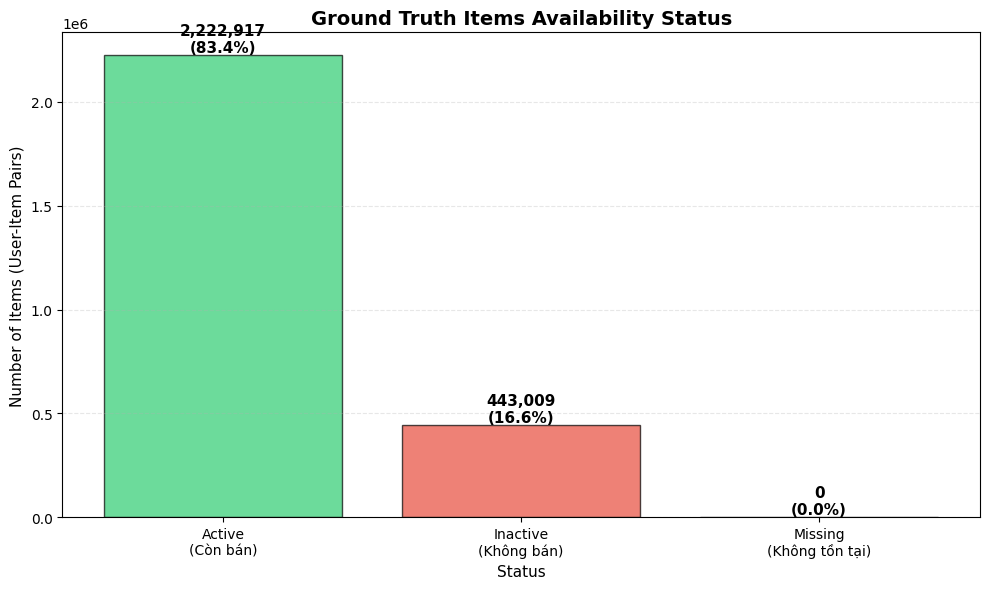


📊 Chart displayed successfully!


In [33]:
# Simple bar chart data
import matplotlib.pyplot as plt

# Prepare data
categories = ['Active\n(Còn bán)', 'Inactive\n(Không bán)', 'Missing\n(Không tồn tại)']
counts = [
    active_items.height,
    inactive_items.height,
    missing_items.height
]
colors = ['#2ecc71', '#e74c3c', '#95a5a6']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    pct = count/total_gt_items*100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Ground Truth Items Availability Status', fontsize=14, fontweight='bold')
plt.ylabel('Number of Items (User-Item Pairs)', fontsize=11)
plt.xlabel('Status', fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n📊 Chart displayed successfully!")